In [36]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ER 131] Homework 7: Resampling

The past few assignments focused on determining model coefficients using different methods (e.g., ordinary least squares regression with scikit-learn, gradient descent...). This assignment takes a step back and explores resampling techniques. The point of resampling is to figure out how well a model will perform on data it hasn't seen yet. Generally, when we resample, we use different subsamples of our observation data to fit a bunch of models of the same form (e.g., linear models), and then look at how the results differ from model to model. This process allows us to tune hyperparameters and calculate values like the variance of our model coefficients or expected value of the mean squared error.

We've done a version of resampling in the past (Lab 5), where we randomly subset our data into training and testing sets. The resampling methods that we're covering now are more systematic than random subsets and are designed to ensure that all of the observations are included when training the models.

In this homework, you will work with the cross-validation method that was introduced in lecture and in Lab 7. 

A good reference here is ISLR Ch. 5.

### Learning Objectives
By the end of this homework, you should be able to:
* Implement a basic model by fitting coefficients to a dataset
* Identify when a model has high bias or variance, and how to optimize the bias-variance tradeoff
* Implement k-fold cross-validation 
* Explain how different model hyper-parameters lead to unique bias-variance

### Table of Contents

1. [Project](#proj)<br>
1. [Overfitting](#of)<br>
1. [Cross Validation](#cv)<br> 


----

## Section 1: Project (5 pts)<a name='proj'></a>

This week, your group should work collaboratively to refine your research question and identify candidate data sources. You may develop answers to Questions 1.1 as a group, but if you do so, please identify each member's unique contribution (for example: "Dawson summarized reports or datasets #1-2, Duncan summarized reports or datasets #3-4...")

**Question 1.1** Give some context for your prediction problem. Have you come across any work that answers questions that are similar or related to the ones that you are asking? What results have they found? What are you hoping to do differently from other researchers who have asked similar questions?<br>

We're definitely not expecting you to review a lot of academic papers and projects for this question, but you should take a look around to see if there are any papers or reports that ask similar questions or use similar data. Beyond giving the reader context for your project in your final report, looking at other people's work can give you ideas for how to approach your own project. 

One way you could approach this question is for each team member to identify and summarize 1-2 relevant citations. Summaries should focus less on the specifics of other papers and more on how findings in the literature inform and motivate your research question. Ultimately, you can use this early work to inform the introduction and motivation sections of your final project.

**Prediction Problem Context:**

*YOUR ANSWER HERE*

---

## Section 2: Overfitting <a name='of'></a>

In this class, we have been using mean squared error (MSE), which takes the following form, as a way of quantifying error from our models:

$$
\text{MSE} = \frac{1}{n}\sum\limits_{i=1}^{n}\Big(y_i-\hat{f}(x_i)\Big)^2
$$

where $y_i$ is our observed $y$ and $\hat{f}(x_i)$ is our estimator's best guess of the value $y$.

Our goal is to lower the MSE assocated with our model. However, in doing so, we risk overfitting if we minimize MSE on our data without considering how the model might perform on data that it hasn't seen before. As a basic example, we will try to choose a model with multiple parameters to fit linear data (with some noise added). By now, you should have a good idea of the variables that go into a linear model, and how to fine-tune them to decrease MSE.

**Dependencies:**

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

We are going to create some pseudo-random data for the purposes of this homework. Read the block below before moving on. Try to figure out what each variable represents. The answers for three of the variables are described below.

In [38]:
# Run this block
n = 100
sigma_2 = 256
noise = np.random.normal(scale=np.sqrt(sigma_2), size=n)
X = np.random.uniform(-5, 5, n)
Y = 10 +7 * X  - 5 * X**2 - 2.5 * X**3 + 0.25 *X**4
Y_obs = Y + noise

* `n`: the number of datapoints in our space.
* `X`: the x-values of our data
* `Y`: is the non-biased estimator of our data (i.e. our response variable without any noise added). 
* `Y_obs`: The observed value of our response variable, Y. 

**Question 2.0 (1pt):** Why do we add noise to our Y variable to create Y_obs?

YOUR ANSWER HERE

*POSSIBLE SOLUTION:* This is a common practice in statistical modeling because in the real world, observed data is subject to measurement error. There is inherent noise in real data, so when we build and test statistical methods, we'd like to make sure they're robust to the presense of noise.

**Question 2.1 (2pts):** The `np.random` method is used in both the 4th and the 5th lines of code above. What is the difference between how random numbers are generated for `noise` versus `X`?


*Hint:* This [link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) and this [link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) may help you.

*YOUR ANSWER HERE*

*EXAMPLE SOLUTION*
The main difference is the type of distribution from which each generator draws. `np.random.normal` draws values drawn from a normal distribution, while `np.random.uniform` draws values from a uniform distribution. As a correlary, the two methods have different approaches to selecting the range of values from which random numbers are drawn. In `np.random.uniform`, we directly specify the upper and lower bounds of our range (in this case, -5 and 5). In `np.random.normal`, we use the `loc` and the `scale` parameters to set the mean and standard deviation, respectively, of the normal distribution. 

We've now set up an experiment where we know (because we defined it above) the relationship between `Y` and `X`, but we're going to try to predict that relationship using `Y_obs`, which are our "observed" values of `Y`. Let's start the prediction process with a visualization.


**Question 2.2 (1pt):** Create a scatterplot of the values of `Y_obs` versus `X`. You may need to make the dots smaller (or the plot bigger) to avoid too much crowding of datapoints. Be sure to give your plot a title and axis labels.

In [39]:
# YOUR CODE HERE

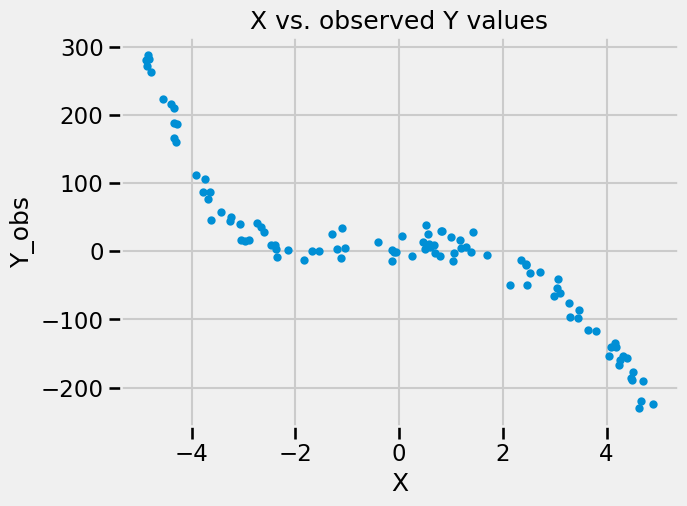

In [40]:
# ANSWER
plt.scatter(X,Y_obs, s = 20)
plt.xlabel('X')
plt.ylabel('Y_obs')
plt.title('X vs. observed Y values');

**Question 2.3 (2pts):** We want to build a model to predict the relationship between `X` and `Y_obs`. When fitting the coefficients to figure out the relationship between `Y_obs` and `X`, we'll start with a general model form. Below is the formula for a model with five parameters, using a 4th order polynomial.

$$ \Large
\hat{y_i} = \hat{\beta_0} + \hat{\beta_1} x_i + \hat{\beta_2} x_i^2 + \hat{\beta_3} x_i^3 + \hat{\beta_4} x_i^4
$$

In the block below, describe in one sentence what each variable represents. The first one is done as an example:

YOUR ANSWER HERE:

* $x_i$: For each observation $i$, this is the x-value at that point. 
* $\hat{y_i}$: YOUR ANSWER HERE
* $\hat{\beta_0}$: YOUR ANSWER HERE
* $\hat{\beta_3}$: YOUR ANSWER HERE


*EXAMPLE SOLUTION:*

* $x_i$: For each observation $i$, this is the x-value at that point. 
* $\hat{y_i}$: This is the estimated value of $y_i$ based on our model's parameters.
* $\hat{\beta_0}$: This is the intercept of the model.
* $\hat{\beta_3}$: This is the coefficient of the term $x^3$.

Now that we have a good grasp of what our dataset represents, we are going to try to find a model that best reproduces the relationship between $x$ and $y$. To do this, we need to split our data into train and test sets.

**Question 2.4.1 (1pt):** What are the benefits of splitting our data into a training and testing set for building a model? 

YOUR ANSWER HERE

*POSSIBLE ANSWER:* Splitting our data into training and testing ensures that we do not over or under fit on our dataset. It gives us the ability to try our model on data that it has never seen before and gives us a realistic estimate of how well our model would perform with new data, which is often our objective. 

**Question 2.4.2 (1pt):** Below, take our data `X` and `Y_obs` and create new data arrays for our new training and test sets. There should be 75% data inside of our training set, and 25% data in our test set. Use the `train_test_split()` function in the `sklearn.model_selection` library (also used in Lab 7) with a random state of 123.

In [ ]:
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(...)

In [41]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, Y_obs, test_size=0.25, random_state = 123)

In [42]:
# Check that the correct number of observations are in the training dataset
assert [np.size(X_train), np.size(y_train)] == [75, 75]

**Question 2.5 (2pts):** Create a function, `scatter()`, that plots the training and testing data on the same scatter plot. Write a [docstring](https://google.github.io/styleguide/pyguide.html#383-functions-and-methods) that describes the objective of the function, along with its inputs and outputs. This function will be useful later on, when we'll be outputting the scatter plot but overlaying different model fit lines on it - it will help to avoid copy-pasting code. 

* As input, your function should take in `X_train`, `X_test`, `y_train`, `y_test`, and a title (given as a string). 
* Use different markers and/or marker colors to denote training and testing data. 
* Add a legend, axis labels, and a title (the title should change based on the input to the function).

After you've defined your function, call it in the second cell to produce a scatter plot of training and testing data.

In [43]:
def scatter(X_train, X_test, y_train, y_test, title) -> None:
    ''' [one line description of the function]

    [longer description of the function]
    
    Args:
        X_train: [description of the X_train argument]
        X_test: [description of the X_test argument]
        y_train: [description of the y_train argument]
        y_test: [description of the y_test argument]
        title: [description of the title argument]
        
    Returns: 
        None
    '''
    
    plt.scatter(x = ..., y = ..., c='blue', s=20, label = 'training') # plot the training data
    ... # plot the testing data
    ... # add a legend
    ... # add axis labels 
    ... # add a title

In [45]:
# solution
def scatter(X_train, X_test, y_train, y_test, title) -> None:
    ''' Plot the training and testing data on the same plot

    A function to plot the train/test split, 
    with different markers and/or marker colors 
    to denote training and testing data. 
    
    Args:
        X_train: training input for X
        X_test: testing input for X
        y_train: training output for y
        y_test: testing output for y
        title: string title for the plot
        
    Returns: 
        None
    '''
    
    plt.scatter(X_train, y_train, c='blue', s=20, label = 'training')
    plt.scatter(X_test, y_test, c='goldenrod', s=20, label = 'testing')
    plt.legend()
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y_obs")

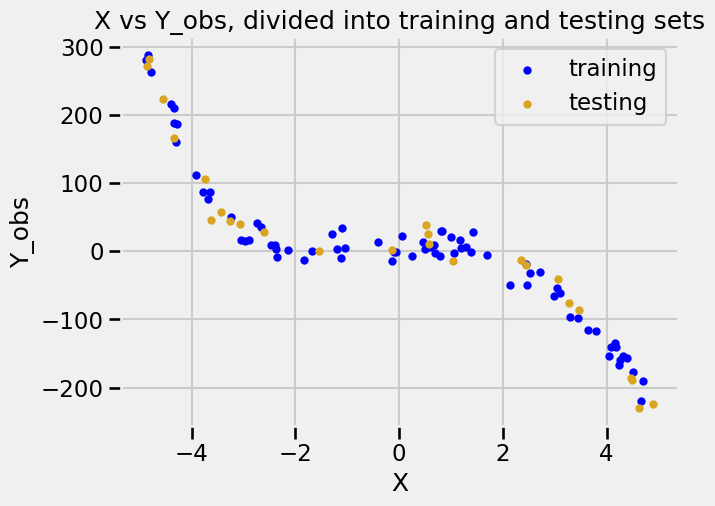

In [46]:
# Test your function
scatter(X_train, X_test, y_train, y_test, "X vs Y_obs, divided into training and testing sets")

It's time to fit our first model! What if we weren't sure what the general model form looked like? One approach we could take is to start the most simple model (i.e., a model with only one or two parameters) and improve from there. So, that is exactly what we will do - we will create a ***feature matrix,*** $\Phi$. $\Phi$ is a matrix with $d$ columns, where each column contains the values of $X$ raised to a power from 1 to $d$. The general form of $\Phi$ looks like this:

$$ \large
\Phi_d(x) = \left[x, x^2, \ldots, x^d \right]
$$

For a first order model, $d$ would be equal to 1 and $\Phi$ would look like this:

$$ \large
\Phi_1(x) = \left[x \right]
$$


Similarly, for a second order model, $d$ would be equal to 2 and $\Phi$ would be:

$$ \large
\Phi_2(x) = \left[x, x^2 \right]
$$

Depending on how many features (degrees) we are adding to our model, we account for it using the following function:

In [47]:
def poly_phi(d, X):
    '''Generate a feature matrix with a unique number of x terms
    
    Args:
        d: Number of unique features
        X: Input data
        
    Returns: 
        A feature matrix with d columns, where each column contains the values 
        of X raised to a power from 1 to d.
    '''
    phi = []
    for i in range(1,d+1):
        phi.append(X**i)
    return np.array(phi).T

Before applying the function `poly_phi()` to our data, let's create a simple array `X_sample`. Run the cell below and make sure you understand how `poly_phi()` is working. Try changing the value for `d` from 1 to 2, 3, and so on to see how the output matrix changes for different degree values.

In [48]:
d = 1
X_sample = np.array([1,2,3])

test = poly_phi(d,X_sample)
print(test.shape)
test

(3, 1)


array([[1],
       [2],
       [3]])

**Question 2.6 (3pts)**: Define a function `lm_phi()` that performs a linear regression using a $\Phi_d$ matrix. 
* As input, it should take X_train, X_test, y_train, y_test, and d (the degree of matrix $\Phi_d$). 
* It should produce a scatter plot of the training and testing data (using the function `scatter()`) with a curve overlayed that shows the result of the linear regression.
* It also should return the mean squared error of the test data and of the training data.

*Hint1:* Carefully think through what the X and y inputs are for each part of this problem. You might need to call poly_phi() more than once...

*Hint2*: Refer to Lab 5 and HW5 if you need a reminder of how to initiate and fit a linear model and use that model to make predictions. You can also review the documentation for `LinearRegression` [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

*Hint3*: When it comes to plotting a the curve of a model in matplotlib, it sometimes make sense to create a range of `X` values, `X_plot`, then generate predictions for each of those. If you generate predictions for your `X_test` values and plot those, matplotlib will basically "connect the dots." However, since the `X_test` values aren't sorted, you'll end up with a plot that has lines crossing each other. If, instead, you define a range of values `X_plot`, then generate predictions for each of those, you'll get a curve - matplotlib is still connecting the dots, but now that it's been given a sequential set of values, it will do so in a way that actually reflects the shape of the function. To get you started, we've defined a variable `X_plot` below that you can use to generate predictions.<br>

When you calculate the test MSE, however, you should be using `X_test` (and getting predictions based on those values) rather than `X_plot`.

In [13]:
# Replace the ellipses with your code
def lm_phi(d, X_train, X_test, y_train, y_test):
    phi_train = ... # get the phi matrix for the training data
    phi_test = ... # get the phi matrix for the test data
    
    # fit a model using training data
    lm = ... # initialize a LinearRegression model
    lm.fit(...) # fit using the phi_train and y_train
    
    X_plot = np.linspace(np.min(X), np.max(X), 200) # See Hint #3
    y_plot = ... # Predict the values of y for each observation in X_plot. 
    
    title = 'Order-{} Linear Model on Train and Test Data'.format(d) # plot title
    scatter(...) # create scatter plot using the scatter function you created earlier
    plt.plot(...) # add the regression (i.e., best fit) curve to your scatter plot.
    
    MSE_test = np.mean((lm.predict(phi_test)-y_test)**2) # calculate MSE of test data
    MSE_train = ... # calculate MSE of training data
    
    return MSE_test, MSE_train

In [49]:
# SOLUTION: 1 point for fitting the linear model to the training data; 1 point for producing the plot; 1 point for the MSEs.
def lm_phi(d, X_train, X_test, y_train, y_test):
    phi_train = poly_phi(d, X_train)
    phi_test = poly_phi(d, X_test)
    
    lm = LinearRegression()
    lm.fit(phi_train, y_train)
    
    X_plot = np.linspace(np.min(X), np.max(X), 200)
    y_plot = lm.predict(poly_phi(d, X_plot))
    
    title = 'Order-{} Linear Model on Train and Test Data'.format(d)
    scatter(X_train, X_test, y_train, y_test, title)
    plt.plot(X_plot, y_plot, c = "mediumvioletred");

    MSE_test = np.mean((lm.predict(phi_test)-y_test)**2)
    MSE_train = np.mean((lm.predict(phi_train)-y_train)**2)
    
    return MSE_test, MSE_train

**Question 2.7 (2pts)**: Call `lm_phi()` with `d = 1` to fit a model using the $\Phi_1$ matrix. Print the testing and training MSEs and visually inspect your plot to answer these questions:
* Does our model have high bias or high variance?
* How do we know? 

Your figure will look something like this:

<img src='hw7_2-7.png' width="50%" height="50%"></img>

In [ ]:
# YOUR CODE HERE
MSE_test, MSE_train = lm_phi(...)
print("test MSE:", MSE_test)
print("training MSE:", MSE_train)

YOUR ANSWER HERE:
1. High bias or variance:
2. We know because ...

test MSE: 3633.010737068667
training MSE: 2478.525356215082


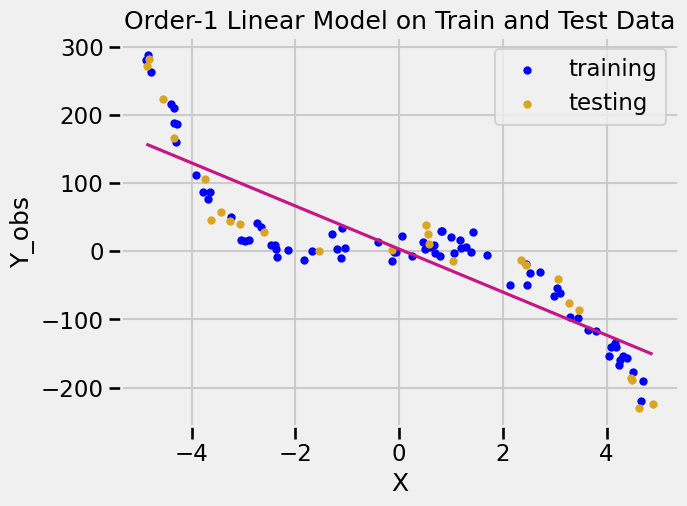

In [50]:
# solution
MSE_test, MSE_train = lm_phi(1, X_train, X_test, y_train, y_test)
print("test MSE:", MSE_test)
print("training MSE:", MSE_train)
# plt.savefig('hw7_2-7.png')

*POSSIBLE SOLUTION:* This model has high bias, and we know because the line is systematically over- and under- fitting the data for different ranges of x values. 

Fitting the model with `d = 1` is a good start, but we're **underfitting** the model - we're not quite capturing the underlying trend of the data when we fit just the one feature. How do we fix this?

Let's try a different approach: instead of fitting just one feature, we'll fit many. Let's try creating a 30th-order polynomial estimator. 



**Question 2.8 (2pts)**: Call `lm_phi()` with `d = 30` to fit a model using the $\Phi_{}$ matrix. Print the testing and training MSEs. After you've called `lm_phi()`, try using `plt.ylim()` to "zoom in and out" of your plot and get a better look at how the model varies with `X`, and output the plot with the y axis limits that best show how the model is responding to the training data.

In [ ]:
# YOUR CODE HERE
MSE_test, MSE_train = ...
plt.ylim(...)
print("test MSE:", MSE_test)
print("training MSE:", MSE_train)

test MSE: 17161.507269180336
training MSE: 202.47315057302046


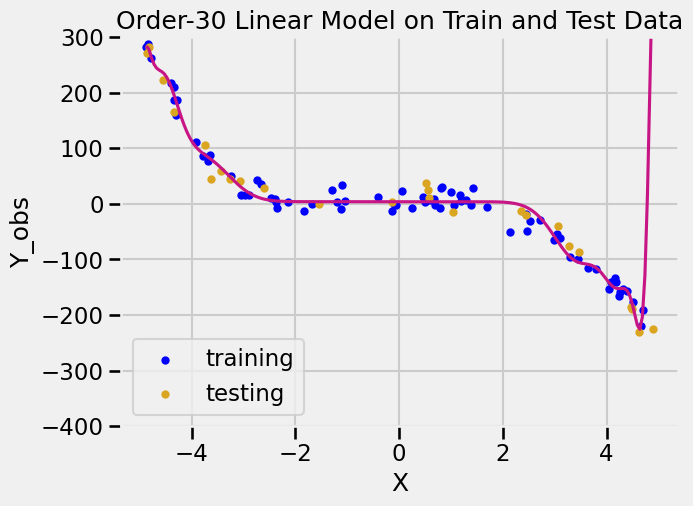

In [51]:
# SOLUTION
MSE_test, MSE_train = lm_phi(30, X_train, X_test, y_train, y_test)
plt.ylim(-400,300)

print("test MSE:", MSE_test)
print("training MSE:", MSE_train)

**Question 2.9 (2pts)** How did the values for training and test MSE change when you changed your feature matrix from having one column (`d = 1`) to 30 columns (`d = 30`)? What do the testing and training MSEs indicate about the relative bias and variance of the two models?

*Your answer here*

*Possible answer: when `d = 1`, the training MSE and testing MSE are within the same order of magnitude. When `d = 30`, the test MSE increases dramatically and the training MSE decreases dramatically. This happens because when we add more features to our model and train it on just the training data, we end up with a model that's a much a closer fit to the training data (reducing bias) but, as a result, the model performs poorly when it sees new data - it has high variance and is not very generalizable.*

**Question 2.10 (1pt)** Try running `lm_phi()` with different values for `d`. Choose the model that provides (visually and based on MSE values) the best fit of training and testing data. 

*Note*: you don't have to systematically loop through all values for `d` and choose the optimal one - we'll do that in the next section. You can just try different values for `d` and settle for one - you will probably find that there's a small range of values for `d` that give roughly similar model fits.

In [19]:
# YOUR CODE HERE

(272.99481773229434, 184.62642785393055)

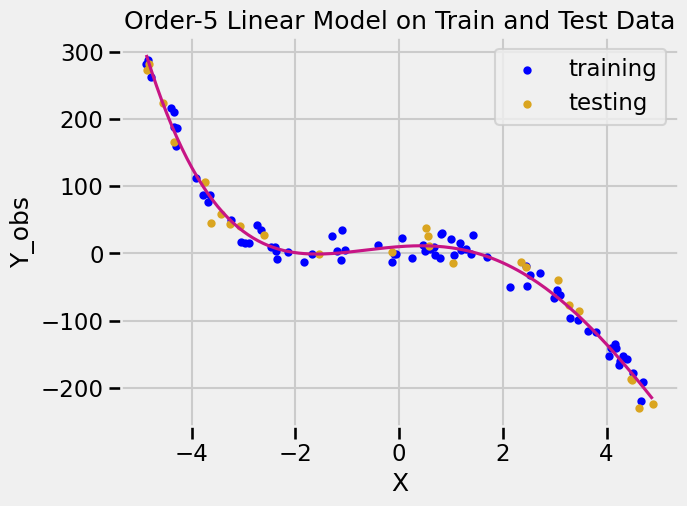

In [52]:
lm_phi(5, X_train, X_test, y_train, y_test)
# values between ~4-6 all give similar, reasonable curves

----

## Section 3: Cross Validation<a name='cv'></a>

You have now estimated the best fit for the data we created. Let's think about the steps we took to get to a successful answer: 

1. First, we started with a simple first-order polynomial to have a baseline training error.
1. We noticed from our graphing that it had high bias, so we continued to add more features...
1. ... until we reached a point in which both the training data and the test data would both be well-fit with the number of features we have chosen.

In Section 2, we had to look outside of our training data to choose the best number of features, and were trying to visually determine which model best fit both the training and test sets. The number of features $d$ is a hyperparameter; we can't choose and tune it using a conventional training process, so we have to select from among many models with many different sets of features. While in previous weeks we used an adjusted $R^2$ or $AIC$ to help us choose the optimal model, here we are instead going to tune this hyperparameter $d$. This is where k-fold cross validation (CV) comes in!


**k-fold cross validation** is a systematic way to make sure that we train the model at least once on every point in the dataset.

<img src='kfoldcv.png' width="50%" height="50%"></img>

The figure above, from ISLR, shows an example of 5-fold cross validation. A k-fold cross validation algorithm randomly splits the data into k groups, ensuring that they're non-overlapping (i.e. each of the k groups has a validation set, and each validation set contains a distinct set of observations). In the figure above, each beige section represents about a fifth of the data set, and the model is fit 5 times with the remaining 4/5 of the data. We'll end up with 5 values for MSE, and we can calculate metrics like the average MSE or the variance of MSE to assess how the model responds to new data.

**Question 3.1 (1pt):** Let's practice splitting training data into k-folds for validation purposes. Split the array `X` from Section 2 into 5 folds, shuffling before we add the batches, with a random state of 123. For each fold, print the indices of the Train and Validation sets onto the console.

In [ ]:
# Replace ellipses with your code

kf = KFold(n_splits = ..., shuffle = ..., random_state = ...)

fold = 1
for train_i, val_i in kf.split(...):
    print("Fold", ...) # print the fold number
    print("Train:", ..., "Test:", ..., '\n') # print training and validation data indices
    fold+=1

In [53]:
# Your code here

kf = KFold(n_splits = 5, shuffle = True, random_state = 123)

fold = 1
for train_i, val_i in kf.split(X):
    print("Fold", fold)
    print("Train:", train_i, "Test:", val_i, '\n')
    fold+=1

Fold 1
Train: [ 1  2  3  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 25 26 27 29 30
 31 32 33 34 35 36 37 39 40 41 43 44 45 46 47 48 49 51 52 53 54 55 57 58
 59 61 62 64 66 67 68 69 71 72 73 74 78 79 80 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99] Test: [ 0  4  5  8 23 24 28 38 42 50 56 60 63 65 70 75 76 77 81 82] 

Fold 2
Train: [ 0  1  2  3  4  5  6  7  8 10 11 13 14 15 16 17 18 20 22 23 24 25 26 27
 28 30 32 34 36 37 38 39 40 42 43 44 45 46 47 48 49 50 51 52 54 55 56 57
 58 59 60 61 63 64 65 66 67 68 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 86 89 92 93 94 96 98 99] Test: [ 9 12 19 21 29 31 33 35 41 53 62 69 84 85 87 88 90 91 95 97] 

Fold 3
Train: [ 0  2  3  4  5  7  8  9 10 12 13 15 17 18 19 21 22 23 24 25 27 28 29 31
 32 33 34 35 36 38 39 40 41 42 46 47 48 49 50 52 53 55 56 57 58 60 61 62
 63 64 65 66 67 68 69 70 71 73 75 76 77 78 80 81 82 83 84 85 86 87 88 90
 91 92 93 94 95 96 97 99] Test: [ 1  6 11 14 16 20 26 30 37 43 44 45 51 54 59 72 74 79 89 98] 

Fold 4
Train:

You'll notice that each test set is distinct from the others, meaning that none of the test sets share common items even though they are shuffled pretty well. 

**Question 3.2 (1pt):** Let's do a little review first before you start implementing the k-fold CV. Complete the function below to calculate the mean squared error between given arrays of predicted and true y-values.

In [23]:
def mse(y_pred, y_true):
    # YOUR CODE HERE
    return ...

In [54]:
# ANSWER
def mse(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

Recall back to Section 2 when you tried different numbers of features (d in lm_phi) to train models. We can use k-fold CV to find out which model has the lowest mean squared error when predicting y-values. Let's define an array, `d_array`, of possible `d` values to evaluate:

In [55]:
# run this cell
d_array = np.arange(1,30)

**Question 3.3 (4 pts):** Complete the function `mse_k_fold_lr` below. We are seeking to create a new k-fold CV pipeline that will give us the information we need to evaluate which features to include in our model based on the average cross-validated MSE of several models. 
* The inputs to the function include the number of folds (given by input `k`); the array of possible d values to evaluate (`d_array`, defined above); the `poly_phi` function defined in Section 2; the `mse` function defined in Question 3.2; the $X$ and $y$ arrays; and a random state given by the integer input `rand_state`. 
* Make sure to shuffle the indices when creating your folds.
* Your function should return a **dictionary** in which each key represents the degree of the highest polynomial in the model (i.e., the d-value associated with a model), and the value is the average value **validation** MSE associated with that model across all k folds. The dictionary should be saved in a variable called `average_mses`.<br>
* Your function should also return the d (degree) value that minimizes MSE across all models. 

This is a somewhat long function, but the code skeleton is written for you - focus on understanding what each step is trying to achieve (from the comments and from your understanding of k-fold cross-validation) and filling in code where you see ellipses (...). You must also fill in the function description in red to get full credit. 

In [26]:
# ANSWER
def mse_k_fold_lr(k, d_array, poly_phi, mse, X, y, rand_state):
    ''' [brief one-line summary of the function]

    [longer summary of the function]
    
    Args:
        k: ...
        d_array: ...
        poly_phi: ...
        mse: ...
        X: ...
        y: ...
        rand_state: ...
        
    Returns: 
        A vector of average cross-validated MSE's
    '''
    
    # 1. Initialize K-Fold CV where k = k
    kf = KFold(...)
    
    # 2. Save the MSEs of each split.
    mses = np.full((k,len(d_array)),np.nan)
    # above, we're initializing an array where:
    # every row of mses corresponds to one of the folds
    # every column of mses corresponds to one of the possible d values in d_array
    # for example, mses[0,0] corresponds to the mean squared error for the first fold, using d = 1 (the first element of d_array)
    
    fold = 0 # initialize fold value
    for train_i, val_i in kf.split(X): # this loop iterates through the K folds of our data
        # 2.1 Separate X and Y_obs array into testing and validation sets
        X_fold_train = X[train_i]
        y_fold_train = ...
        X_fold_val = ...
        y_fold_val = ...
        
        # 2.2 Each d value will receive its own LinearRegression() model.
        for i in range(len(d_array)): # this loop iterates through d values to produce a new model for each d value
            # 2.2.1 Initialize the model
            model = ...
            
            # 2.2.2 Fit the training data using feature matrix with a feature matrix generated with X_fold_train raised 
            # up to d[i] degrees (using poly_phi) and the y_fold_train
            model.fit(...)
            
            # 2.2.3 Predict y-values for the set of features comprising the **validation fold** transformed into a feature matrix
            y_pred = model.predict(...)
            
            # Save each mse between y_pred and y_fold_val at their respective fold and d value
            mses[fold, i] = mse(...)
        
        fold += 1 # augment the fold count
    
    # 3. Now, find the average of the MSEs for each d value. Your result should be a dictionary with the same number of elements as d_array,
    # in which each value is the average MSE across all k folds associated with its respective key, i.e., the d-value.
    average_mses = {d: np.mean(mses[:,d]) for d in range(len(d_array))}
    
    # 4. Find the index of the minimum average MSE
    min_mse_index = min(average_mses, key=average_mses.get)
    
    print("Minimum MSE Parameters:", min_mse_index, '\n',
          "MSE of {} Parameters:".format(min_mse_index), average_mses[min_mse_index])
    return average_mses

In [56]:
# SOLUTIONS
def mse_k_fold_lr(k, d_array, poly_phi, mse, X, y, rand_state):
    ''' Run cross validation for polynomial regression

    Implement a full cross-validation pipeline for d-dimensional polynomial regression.
    This function will print the d (degree) value that gives the smallest MSE.
    
    Args:
        k: number of folds
        d_array: array of d-values we want to test
        poly_phi: function to create the feature matrix
        mse: mean square error function
        X: input data
        y: output data
        rand_state: random state
        
    Returns: 
        A vector of average cross-validated MSE's
    '''
    
    # 1. K-Fold where k = k
    kf = KFold(n_splits = k, shuffle = True, random_state = rand_state)
    
    # 2. Save the MSEs of each split.
    mses = np.full((k,len(d_array)),np.nan)
    # every row of mses corresponds to one of the folds
    # every column of mses corresponds to one of the possible d values in d_array
    # for example, mses[0,0] corresponds to the mean squared error for the first fold, using d = 1 (the first element of d_array)
    
    fold = 0 # initialize fold value
    for train_i, val_i in kf.split(X):
        # 2.1 Separate X and Y_obs array into respective variables
        X_fold_train = X[train_i]
        y_fold_train = y[train_i]
        X_fold_val = X[val_i]
        y_fold_val = y[val_i]
        
        # 2.3 Each d value will receive its own LinearRegression() model.
        for i in range(len(d_array)):
            # 2.3.1 Create a linear regression model
            model = LinearRegression()
            
            # 2.2.2 Fit the training data using feature matrix with a feature matrix generated with X_fold_train raised 
            # up to d[i] degrees (using poly_phi) and the y_fold_train
            model.fit(poly_phi(d_array[i], X_fold_train), y_fold_train)
            
            # 2.3.3 Predict y-values for the set of features comprising the **validation fold** transformed into a feature matrix
            y_pred = model.predict(poly_phi(d_array[i],X_fold_val))
            
            # Save each mse between y_pred and y_fold_val at their respective fold and d value
            mses[fold,i] = mse(y_pred,y_fold_val)
        
        fold += 1 # augment the fold count
    
    # 3. Now, find the average of the MSEs for each d value. Your result should be a vector of the same length as d_array,
    # in which each element is the average MSE across all k folds associated with that d-value.
    average_mses = {d: np.mean(mses[:,d]) for d in range(len(d_array))}
    
    # 4. Find the index of the minimum average MSE
    min_mse_index = min(average_mses, key=average_mses.get)
    
    print("Minimum MSE Parameters:", min_mse_index, '\n',
          "MSE of {} Parameters:".format(min_mse_index), average_mses[min_mse_index])
    return average_mses

In [57]:
# Test out your function using five-fold CV and a random state of 1234
average_mses = mse_k_fold_lr(5, d_array, poly_phi, mse, X_train, y_train, 1234)
average_mses

Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 209.37967485484987


{0: 2777.5352421765065,
 1: 2802.2132319787834,
 2: 349.5819642671767,
 3: 209.37967485484987,
 4: 218.77997613182757,
 5: 223.9901426655419,
 6: 218.09407131320754,
 7: 210.25990399260837,
 8: 223.05906936077122,
 9: 225.61797874266844,
 10: 230.4816032632644,
 11: 264.4728678813462,
 12: 274.8001353505733,
 13: 228.2729190210901,
 14: 274.0501526818492,
 15: 449.9353139650566,
 16: 589.824149671025,
 17: 466.08466413316853,
 18: 1427.5441644704467,
 19: 940.4437176037211,
 20: 284.04678285327134,
 21: 618.293691960999,
 22: 15107.55541731276,
 23: 980.7310155743717,
 24: 92979.57473720735,
 25: 107906.73983521659,
 26: 259576.93311854446,
 27: 268579.5576379892,
 28: 44638.30278691589}

**Question 3.4 (2pts)** The function call above for 5-fold cross validation on the training data with a random state of 2022 should have returned many different MSEs, with the minimum MSE corresponding to the value of $d$ that gives us the best model. In lieu of checking an adjusted $R^2$ value or AIC, our cross validation process allows us to directly estimate the test error for these models with different numbers of features. 

The function call should have printed a "Minimum MSE parameters" of 3, with an MSE of about 209, corresponding to the MSE for a model with 3 parameters. In the cell below, experiment with calling `mse_k_fold_lr()` but:

* changing the `rand_state` input but keeping `k` constant
* changing `k` to a larger value, and trying different values of `rand_state`

Then, answer the following questions:

* What are you changing in terms of the implementation of k-fold CV when you change `k`? How about when you change `rand_state`?
* Do the results (minimum MSE parameters and associated MSE) change when you vary `k` or `rand_state`?

In [29]:
# SCRATCH CODE HERE

*Your answer here*

In [58]:
# possible solution 
# changing rand_state but keeping k constant
mse_k_fold_lr(5, d_array, poly_phi, mse, X_train, y_train, 1)
mse_k_fold_lr(5, d_array, poly_phi, mse, X_train, y_train, 123)
mse_k_fold_lr(5, d_array, poly_phi, mse, X_train, y_train, 2024);

Minimum MSE Parameters: 7 
 MSE of 7 Parameters: 209.74678890482937
Minimum MSE Parameters: 7 
 MSE of 7 Parameters: 227.7618562854142
Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 205.69416084488344


In [59]:
# trying different values for k
mse_k_fold_lr(10, d_array, poly_phi, mse, X_train, y_train, 1234)
mse_k_fold_lr(20, d_array, poly_phi, mse, X_train, y_train, 1234)
mse_k_fold_lr(2, d_array, poly_phi, mse, X_train, y_train, 1234);

Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 208.38802621742738
Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 208.84148717320426
Minimum MSE Parameters: 7 
 MSE of 7 Parameters: 208.13450880048234


*Possible Solution*: Changing k changes the number of folds, and changing rand_state changes the observations that are included in each train/validation split. Any atempt to compare MSE across the different values of k and rand_state should receive credit. 

In the exmple above, we see that the minimum MSE is broadly consisant across different values of k and rand_state. However, differences in specification can lead us to choose values of d between 3 and 7. This might have something to do with the shape of third-degree, fifth-degree and seventh-degree polynomials. In situations like this, we might consider using the one-standard-error rule, described on p. 240 of ISLP. 

**Question 3.5:** Use the `matplotlib` or `seaborn` libraries to plot the log of average mean squared error from cross-validation on the y-axis versus the degree of the polynomial (i.e., d) on the x-axis. Your plot should have a marker where the MSE is minimized, and should have axis labels and a title.

*Hint*: you can extract values from a dictionary using `.values()`, and can convert dictionary values to a list using `list()`.

In [32]:
# YOUR ANSWER HERE

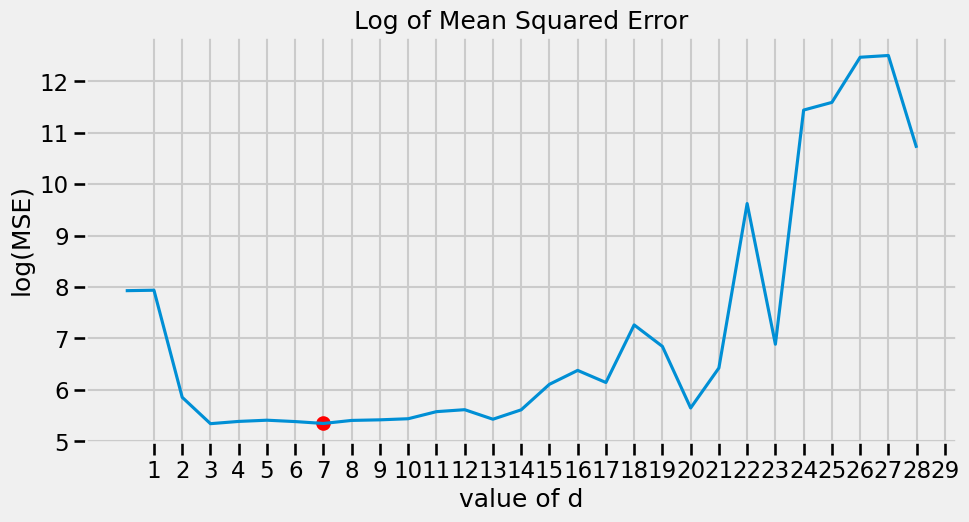

In [60]:
# EXAMPLE ANSWER
# There are multiple correct answers to this question.
log_avg_mses = np.log(list(average_mses.values()))
plt.figure(figsize = (10,5))
plt.plot(average_mses.keys(), log_avg_mses)
plt.xticks(d_array)
plt.scatter(7, log_avg_mses[7], c='r')
plt.title('Log of Mean Squared Error')
plt.xlabel('value of d')
plt.ylabel('log(MSE)');

## Submission

Congrats, you're done with Homework 7!

Before you submit, click **Kernel** --> **Restart & Clear Output**. Then, click **Cell** --> **Run All**. Then, go to the toolbar and click **File** -> **Download as** -> **.pdf** and submit the file **as both an .pdf and .ipynb file through bCourses**.

----